# Báo cáo bài tập lớn môn Học máy 
**Giảng viên**: Trần Quốc Long

**Sinh viên:** Lưu Văn Vương

**MSSV**: 18021446

**Topic**: Quora Insincere Question Classification




# MÔ TẢ BÀI TOÁN
* Quora là nền tảng để mọi người có thể học hỏi lẫn nhau bằng cách đặt câu hỏi và trả lời để chia sẻ kiến thức. Mục đích của bài toán này là để phân loại các câu hỏi đặt ra là thuộc loại câu hỏi chân thành hay không chân thành. 
* Những câu hỏi không chân thành thường là những câu đưa ra tuyên bố quan điểm của mình hơn là để tìm những câu trả lời có ích: không trung lập, khiêu khích hoặc chê bai, không có căn cứ thực tế hoặc chứa nội dung khiêu dâm.
* Input: Câu hỏi dạng text
* Output: 0/1 (Sincere/ Insincere)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# PHÂN TÍCH DỮ LIỆU

**Import các thư viện cần thiết:**

**Đọc các file**

In [ ]:
# import os
import json
import string
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

**Đọc các file**

In [ ]:
#Đọc file train và file test
train_df = pd.read_csv("../input/quora-insincere-questions-classification/train.csv")
test_df = pd.read_csv("../input/quora-insincere-questions-classification/test.csv")
print("Train shape : ", train_df.shape)
print("Test shape : ", test_df.shape)

**Nhận xét:**

**File train.csv:**
* Số dòng: 1306122
* Số cột: 3 (cột qid, question_text, target)

**File test.csv:**
* Số dòng: 375806
* Số cột: 2 (cột qid, question_text)

**Thông tin về các trường:**
* Cột qid: Đây chính là id của câu hỏi, không có 2 câu hỏi nào có id giống nhau.
* Cột question_text: Đây chính là cột chứa các câu hỏi. Chúng ta sẽ tiến hành clean dữ liệu trước khi cho vào mô hình để huấn luyện.
* Cột target: Đây chính là cột chứa kết quả đánh giá câu hỏi có phải chân thành hay không chân thành, câu hỏi question_text có target = 0 sẽ được đánh giá là câu hỏi chân thành, và câu hỏi có target = 1 sẽ được đánh giá là không chân thành.

In [ ]:
train_df.info()

**Nhận xét** : Dữ liệu file train không có giá trị null.

In [ ]:
test_df.info()

**Nhận xét:** Dữ liệu file test không có giá trị null.

**Tiếp theo , vẽ biều đồ thể hiện sự phân bố dữ liệu trong tập train**

In [ ]:
cnt_srs = train_df['target'].value_counts()
trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color=cnt_srs.values,
        colorscale = 'Picnic',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Target Count',
    font=dict(size=18)
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="TargetCount")


In [ ]:
print("Tỉ lệ phần trăm số câu hỏi Insincere là:", (len(train_df.loc[train_df.target==1])) / (len(train_df.loc[train_df.target == 0])) * 100)

**Nhận xét về phân lớp dữ liệu:**

Dựa vào biểu đồ trên, ta có thể thấy trong tập train, số lượng câu hỏi đc đánh nhãn là thiếu chân thành chỉ chiếm khoảng 6.19% (80810/1306122 câu) so với tỉ lệ rất cao là 93.81% là những câu hỏi chân thành.

Tỉ lệ giữa 2 nhóm câu hỏi này rơi vào khoảng 1:15 => Tập dữ liệu bị mất cân bằng. Điều này sẽ dẫn đến 1 số vấn đề như sau:
* Đánh giá sai chất lượng mô hình: Với tỉ lệ như trên thì không cần quan tâm đến mô hình ta cũng có thể đạt được độ chính xác cao của metric accuracy, chỉ cần tất cả dự đoán đưa ra đều có target = 0 thì độ chính xác đã đạt gần 94%.
* Mô hình dự đoán kém chính xác: Vì ở đây, mục tiêu của bài toán là xác định các câu hỏi thiếu chân thành, trong khi sự mất cân bằng trên có thể khiến kết quả dự đoán thường nghiêng về nhóm đa số(target = 0) và kém hiệu quả trên nhóm thiểu số (target = 1).

 Do đó không nên lựa chọn độ chính xác(accuracy) làm chỉ số đánh giá mô hình. Thay vào đó ta có thể sử dụng các metric thay thế như: **F1_score, Recall,..**
 
 Số câu hỏi "insincere" chỉ chiếm khoảng 6-7% trong tổng số câu hỏi. Dữ liệu bị mất cân bằng khá lớn, do đó độ đo F1 sẽ thích hợp cho những trường hợp như này

# Phân tích

**Số lượng từ có trong câu**

In [ ]:
words = train_df['question_text'].apply(lambda x: len(x) - len(''.join(x.split())) + 1)
train_df['words'] = words
words = train_df.loc[train_df['words']<200]['words']
sns.distplot(words, color='g')
plt.show()

**Số từ trung bình có trong câu**

In [ ]:
print('Số từ trung bình của các câu hỏi trong dữ liệu file train là {0:.0f}.'.format(np.mean(train_df['question_text'].apply(lambda x: len(x.split())))))
print('Số từ trung bình của các câu hỏi trong dữ liệu file test là {0:.0f}.'.format(np.mean(test_df['question_text'].apply(lambda x: len(x.split())))))

**Số từ xuất hiện nhiều nhất**

In [ ]:
print('Số từ lớn nhất của các câu hỏi trong dữ liệu file train là {0:.0f}.'.format(np.max(train_df['question_text'].apply(lambda x: len(x.split())))))
print('Số từ lớn nhất của các câu hỏi trong dữ liệu file test là {0:.0f}.'.format(np.max(test_df['question_text'].apply(lambda x: len(x.split())))))

**Số kí tự trung bình**

In [ ]:
print('Số ký tự trung bình của các câu hỏi trong dữ liệu file train là {0:.0f}.'.format(np.mean(train_df['question_text'].apply(lambda x: len(x)))))
print('Số ký tự trung bình của các câu hỏi trong dữ liệu file test là {0:.0f}.'.format(np.mean(test_df['question_text'].apply(lambda x: len(x)))))

**Nhận xét**: Có thể thấy độ dài trung bình của các câu hỏi trong tập dữ liệu là giống nhau, tuy nhiên có những câu hỏi khá dài trong tập dữ liệu huấn luyện.

# Phân tích data


In [ ]:
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(train_df["question_text"], title="Word Cloud of Questions")

**Tính các từ xuất hiện nhiều trong các câu hỏi chân thành và không chân thành**

In [ ]:
from collections import defaultdict
train1_df = train_df[train_df["target"]==1]
train0_df = train_df[train_df["target"]==0]

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from sincere questions ##
freq_dict = defaultdict(int)
for sent in train0_df["question_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

## Get the bar chart from insincere questions ##
freq_dict = defaultdict(int)
for sent in train1_df["question_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["top các từ có nhiều trong câu hỏi chân thành", 
                                          "top các từ có nhiều trong câu hỏi ko chân thành"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

**Đầu tiên ta sẽ xử lý data: Bỏ các từ không mang nghĩa và dấu (stopword, punctual), đổi chữ hoa thành chữ thường, lemmatize (đưa tất cả các chữ về một dạng thống nhất)**

In [ ]:
from gensim.utils import simple_preprocess 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english')) 
wordnet_lemmatizer = WordNetLemmatizer()
def preprocessing(corpus):
    res = []
    for doc in corpus:
        words = []
        for word in simple_preprocess(doc):
            if word not in stop_words:
                word1 = wordnet_lemmatizer.lemmatize(word, pos = "n")
                word2 = wordnet_lemmatizer.lemmatize(word1,pos = "v")
                word3 = wordnet_lemmatizer.lemmatize(word2, pos = ("a"))
                words.append(word3)
                pass
            pass
        res.append(' '.join(words))        
        pass
    return res

**NHẬN XÉT:**

Một vài từ xuất hiện nhiều ở cả hai lớp như people, think, many...
Những top words xuất hiện nhiều nhất ở lớp câu hỏi chân thành là : best, will, people...
Những top words xuất hiện nhiều nhất ở lớp câu hỏi ko chân thành là : people, women, will...

# Tiền xử lý data

**Đầu tiên ta sẽ xử lý data**

In [ ]:
from gensim.utils import simple_preprocess 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english')) 
wordnet_lemmatizer = WordNetLemmatizer()
def preprocessing(corpus):
    res = []
    for doc in corpus:
        words = []
        for word in simple_preprocess(doc):
            if word not in stop_words:
                word1 = wordnet_lemmatizer.lemmatize(word, pos = "n")
                word2 = wordnet_lemmatizer.lemmatize(word1,pos = "v")
                word3 = wordnet_lemmatizer.lemmatize(word2, pos = ("a"))
                words.append(word3)
                pass
            pass
        res.append(' '.join(words))        
        pass
    return res

**Đọc lại file train.csv và test.csv đưa về dạng tệp 'train' và 'test'**

In [ ]:
train = pd.read_csv("../input/quora-insincere-questions-classification/train.csv")
test = pd.read_csv("../input/quora-insincere-questions-classification/test.csv")

In [ ]:
# áp dụng cho tập train và test 
train['question_text'] = preprocessing(train['question_text'])
test['question_text'] = preprocessing(test['question_text'])

# Tích xuất

**TF-IDF là gì?**

**TF-IDF (Term Frequency – Inverse Document Frequency)** là 1 kĩ thuật sử dụng trong khai phá dữ liệu văn bản. Trọng số này được sử dụng để đánh giá tầm quan trọng của một từ trong một văn bản. Giá trị cao thể hiện độ quan trọng cao và nó phụ thuộc vào số lần từ xuất hiện trong văn bản nhưng bù lại bởi tần suất của từ đó trong tập dữ liệu. Một vài biến thể của TF-IDF thường được sử dụng trong các hệ thống tìm kiếm như một công cụ chính để đánh giá và sắp xếp văn bản dựa vào truy vấn của người dùng. TF-IDF cũng được sử dụng để lọc những từ stopwords trong các bài toán như tóm tắt văn bản và phân loại văn bản.

**TF** là gì? **TF:** Term Frequency(Tần suất xuất hiện của từ) là số lần từ xuất hiện trong văn bản. Vì các văn bản có thể có độ dài ngắn khác nhau nên một số từ có thể xuất hiện nhiều lần trong một văn bản dài hơn là một văn bản ngắn. Như vậy, term frequency thường được chia cho độ dài văn bản( tổng số từ trong một văn bản).

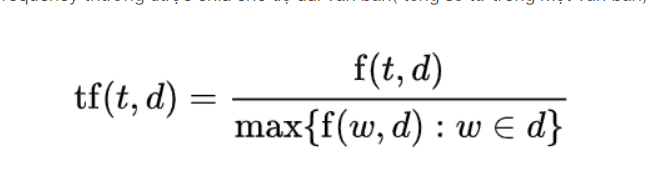

**Trong đó:**

tf(t, d): tần suất xuất hiện của từ t trong văn bản d

f(t, d): Số lần xuất hiện của từ t trong văn bản d

max({f(w, d) : w ∈ d}): Số lần xuất hiện của từ có số lần xuất hiện nhiều nhất trong văn bản d

**IDF** là gì?

**IDF:** Inverse Document Frequency(Nghịch đảo tần suất của văn bản), giúp đánh giá tầm quan trọng của một từ . Khi tính toán TF , tất cả các từ được coi như có độ quan trọng bằng nhau. Nhưng một số từ như “is”, “of” và “that” thường xuất hiện rất nhiều lần nhưng độ quan trọng là không cao. Như thế chúng ta cần giảm độ quan trọng của những từ này xuống.

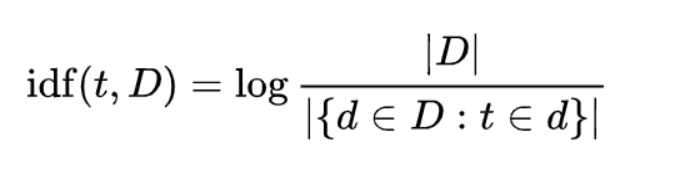


**Trong đó:**

idf(t, D): giá trị idf của từ t trong tập văn bản

|D|: Tổng số văn bản trong tập D

|{d ∈ D : t ∈ d}|: thể hiện số văn bản trong tập D có chứa từ t.

Cơ số logarit trong công thức này không thay đổi giá trị idf của từ mà chỉ thu hẹp khoảng giá trị của từ đó. Vì thay đổi cơ số sẽ dẫn đến việc giá trị của các từ thay đổi bởi một số nhất định và tỷ lệ giữa các trọng lượng với nhau sẽ không thay đổi. (nói cách khác, thay đổi cơ số sẽ không ảnh hưởng đến tỷ lệ giữa các giá trị IDF). Việc sử dụng logarit nhằm giúp giá trị tf-idf của một từ nhỏ hơn, do chúng ta có công thức tính tf-idf của một từ trong 1 văn bản là tích của tf và idf của từ đó.

Cụ thể, chúng ta có công thức tính TF-IDF hoàn chỉnh như sau:

tfidf(t, d, D) = tf(t, d) x idf(t, D)

**Khi đó:**

Những từ có giá trị TF-IDF cao là những từ xuất hiện nhiều trong văn bản này, và xuất hiện ít trong các văn bản khác. Việc này giúp lọc ra những từ phổ biến và giữ lại những từ có giá trị cao (từ khoá của văn bản đó).

In [ ]:
vector = TfidfVectorizer( ngram_range = (1,2))
train_feature_matrics = vector.fit_transform(train['question_text'].values.astype('U'))
test_feature_matrics = vector.transform(test['question_text'].values.astype('U'))

In [ ]:
train_feature_matrics

**Đã xong quá trình tiền xử lý , lúc này dữ liệu cơ bản đã được làm sạch , bây giờ ta sẽ chọn lựa model để thực hiện quá trình train**

# Lựa chọn model

**+ Tìm hiểu về F1-score**
Đầu tiên, Precision được định nghĩa là tỉ lệ số điểm positive mô hình dự đoán đúng trên tổng số điểm mô hình dự đoán là Positive. Recall được định nghĩa là tỉ lệ số điểm positive mô hình dự đoán đúng trên tổng số điểm thật sự là Positive (hay tổng số điểm được gán nhãn là positive ban đầu).

Precision càng cao, tức là số điểm mô hình dự đoán là positive đều là positive càng nhiều. Precision = 1, tức là tất cả số điểm mô hình dự doán là Positive đều đúng, hay không có điểm nào có nhãn là Negative mà mô hình dự đoán nhầm là Positive.

Recall càng cao, tức là số điểm là positive bị bỏ sót càng ít. Recall = 1, tức là tất cả số điểm có nhãn là Positive đều được mô hình nhận ra.

Chỉ dùng Precision, mô hình chỉ đưa ra dự đoán cho một điểm mà nó chắc chắn nhất. Khi đó Precision = 1, tuy nhiên ta không thể nói là mô hình này tốt.Chỉ dùng Recall, nếu mô hình dự đoán tất cả các điểm đều là Positive. Khi đó Recall = 1, tuy nhiên ta cũng không thể nói đây là mô hình tốt. Khi đó F1-score được sử dụng. F1-score là trung bình điều hòa (harmonic mean) của Precision và Recall (giả sử hai đại lượng này khác 0). F1-score được tinh theo công thức:


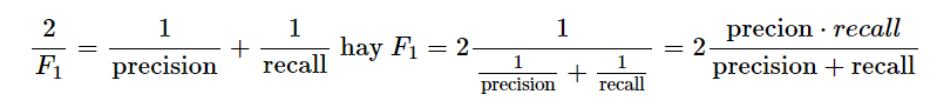


**F1-score** có giá trị nằm trong nửa khoảng (0,1].F1 càng cao, bộ phân lớp càng tốt. Khi cả Recall và Precision đều bằng 1 (tốt nhất có thể), F1 = 1. Khi cả Recall và Precision đều thấp, ví dụ bằng 0.1, F1 = 0.1.

**+  Lựa chọn mô hình huấn luyện: mô hình Logistic Regression**

   -  **Giới thiệu qua về Logistic Regression**  
         Logistic Regression là 1 thuật toán phân loại được dùng để gán các đối tượng cho 1 tập hợp giá trị rời rạc (như 0, 1, 2, ...). Một ví dụ điển hình là phân loại Email, gồm có email công việc, email gia đình, email spam, ... Giao dịch trực tuyến có là an toàn hay không an toàn, khối u lành tính hay ác tình. Thuật toán trên dùng hàm sigmoid logistic để đưa ra đánh giá theo xác suất.
   -  **Học tf-idf đã extract ở trên bằng mô hình Logistic regression. Thử tunning tham số regularize C**
   

In [ ]:
# Khai báo thêm các thư viện được sử dụng
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
train_x, valid_x, train_y, valid_y = train_test_split(train_feature_matrics, train['target'], test_size=0.25, shuffle=False)
C = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000]

**Bây giờ , bắt đầu đi vào quá trình huấn luyện**

In [ ]:
for c in C:
    model = LogisticRegression(solver='liblinear', penalty='l2', C=c)
    model.fit(train_x, train_y)
    prediction = model.predict(valid_x)
    f1 = f1_score(valid_y, prediction)
    acc = accuracy_score(valid_y, prediction)
    print("Regularization: ", c)
    print("F1 score: ",f1)
    print("Acc score: ",acc)

**Nhận xét:** Có thể thấy , giá trị Regularization tốt nhất là 30, Vì hàm predict sẽ trả về một sample là sincere hay không bằng cách so sánh xác suất đầu ra với một giá trị mặc định threshold = 0.5 (decision bound = 0), ta sẽ thử thay đổi mức threshold này

In [ ]:
thresholds = [0.5, 0.1, 0.14, 0.15, 0.16, 0.17, 0.25, 0.3, 0.4, 0.55, 0.7]
c = 30
model = LogisticRegression(solver='liblinear', penalty='l2', C=c)
model.fit(train_x, train_y)
predict = model.predict_proba(valid_x)[:,1]
for t in thresholds:
    predict_t = np.where(predict > t, 1, 0)
    f1 = f1_score(valid_y, predict_t)
    print("Threshold: ", t)
    print("F1 score: ", f1)

**Tại Threshold = 0.15 , giá trị F1 score là tốt nhất cho tập val**

In [ ]:
t= 0.15
predict = model.predict_proba(valid_x)[:,1]
predict = np.where(predict > t, 1, 0)

In [ ]:
confusion_matrix(valid_y, predict)

**Vì số sample có nhãn 1 chỉ chiếm 6% tổng số sample, ta thử sử dụng class weight để cải tiến model. Coi 1 sample có label 1 như 14 samples có label 0.**

In [ ]:
class_weight = {0: 1., 1: 14.}
thresholds = [0.1, 0.25, 0.3, 0.35, 0.4, 0.55, 0.6, 0.7, 0.8, 0.85, 0.9]
c = 30
model = LogisticRegression(solver='liblinear', penalty='l2', C=c, class_weight = class_weight)
model.fit(train_x, train_y)
predict = model.predict_proba(valid_x)[:,1]
for t in thresholds:
    predict_t = np.where(predict > t, 1, 0)
    f1 = f1_score(valid_y, predict_t)
    print("Threshold: ", t)
    print("F1 score: ", f1)

**Model này cho kết quả F1-score không tốt bằng model trước , vì vậy ta sẽ dùng kết quả của model trước để dự toán kết quả cho tập test**

In [ ]:
# Kiểm tra dữ liệu có trong tập test
test.head(20)

In [ ]:
model = LogisticRegression(solver='liblinear', penalty='l2', C=30)
model.fit(train_feature_matrics, train['target'])
predict = model.predict_proba(test_feature_matrics)[:,1]
predict = np.where(predict > 0.17, 1, 0)

In [ ]:
test['prediction'] = predict

# Kết quả dự đoán trong tập test

In [ ]:
test.head(20)

**Kết luận: Mô hình thử nghiệm trên tập test đã cho ra kết quả phân biệt được đâu là câu hỏi chân thành (prediction = 0) và đâu là câu hỏi không trân thành (prediction = 1).**

# Kết luận 

**Tạo file submission .csv chứa kết quả của mô hình.**

In [ ]:
results = test[['qid', 'prediction']]
results.to_csv('submission.csv', index=False)